In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy
import umap
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import Voronoi, voronoi_plot_2d

from methods import Hexagon, HexagonalGCs, permutation_test
from models import Similitude
from plotting_functions import scatter3d
from utils import rotation_matrix

In [29]:
# load trained model
model = torch.load('./saved-models/Similitude2-14-dirac')

# ---> OVERLOAD/PRUNE/ABLATE PHASES <---
# random uniform
#phases = model.unit_cell.sample(6)
#phases = np.random.uniform(0,0.2,size=model.phases.shape)
#model.phases = torch.nn.Parameter(torch.tensor(phases,dtype=torch.float32))
#mask = torch.linalg.norm(model.phases+0.2,axis=-1) > 0.4
#model.phases = torch.nn.Parameter(model.phases[mask])
# ---

if False:
    # Overwrite Initial Phase Placements
    start_phases = model.unit_cell.sample(4)
    model.set_phases(start_phases)

phases = model.phases.clone().detach().numpy()
wrapped_phases = model.unit_cell.wrap(phases)

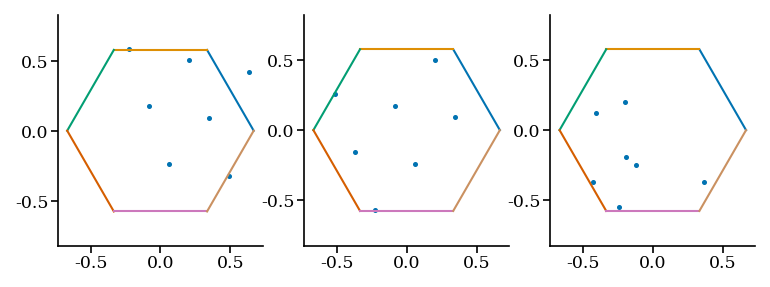

In [30]:
fig, axs = plt.subplots(ncols=3,figsize=(3*2,2))
axs[0].scatter(*phases.T,s=2)
axs[1].scatter(*wrapped_phases.T,s=2)
axs[2].scatter(*model.unit_cell.sample(phases.shape[0]).T,s=2)
[axs[i].axis('equal') for i in range(len(axs))]

[model.unit_cell.plot(fig,axs[i]) for i in range(len(axs))]
fig.subplots_adjust(wspace=0.2)

In [5]:
def hex_radius(phases, model):
    cdists = np.stack([model.unit_cell.geodesic(phases[i:i+1],phases) for i in range(len(phases))])
    off_diag_mask = ~np.eye(cdists.shape[0],dtype=bool)
    return np.mean(cdists[off_diag_mask]), np.std(cdists[off_diag_mask])

def hex_orientation(phases, model, degrees=True):
    # mirror x and y since arctan2 takes y as first argument and x as second
    angles = np.stack([np.arctan2(*(model.unit_cell.wrap(phases - phases[i]))[:,::-1].T) 
                       for i in range(len(phases))])
    # modulo 60 degrees
    angles = angles % (np.pi/3)
    angles = angles * 180/np.pi if degrees else angles
    off_diag_mask = ~np.eye(phases.shape[0],dtype=bool)
    return np.mean(angles[off_diag_mask]), np.std(angles[off_diag_mask]) 

(-0.5646144120229615,
 1.0009033019344011,
 -0.6144786758969227,
 0.5875125767870082)

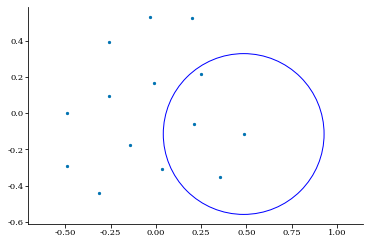

In [30]:
#model.set_phases(np.concatenate([phases,phases+0.1]))
#model.set_phases(np.concatenate([phases,phases@rotation_matrix(30).T+0.1]))
fig,ax=plt.subplots()
phases = model.phases.detach().numpy()
wrapped_phases = model.unit_cell.wrap(phases)
ax.scatter(*wrapped_phases.T,s=5)
circle = plt.Circle(phases[4], model.unit_cell.radius*2/3, color='b', fill=False)
#circle = plt.Circle(phases[6], 0.3, color='b', fill=False)
ax.add_patch(circle)
plt.axis('equal')

In [7]:
cdists = np.stack([model.unit_cell.geodesic(phases[i:i+1],phases) for i in range(len(phases))])
mask = np.triu_indices(cdists.shape[0],k=1)
sort_idxs = np.argsort(cdists[mask])

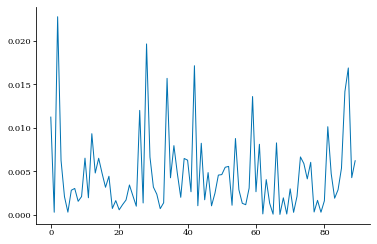

In [8]:
plt.plot(np.diff(cdists[mask][sort_idxs]))

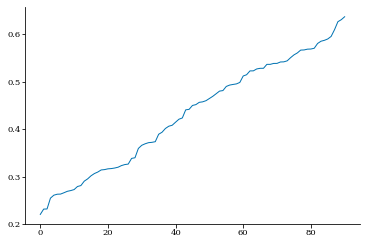

In [9]:
plt.plot(cdists[mask][sort_idxs])

In [10]:
radius, _ = hex_radius(wrapped_phases,model)
orientation, _ = hex_orientation(wrapped_phases,model)
hexagons = [Hexagon(radius, orientation, wrapped_phases[i]) for i in range(len(phases))]

(-0.5546681956078308,
 0.7920327572166566,
 -0.8522762320949583,
 0.5988362699392956)

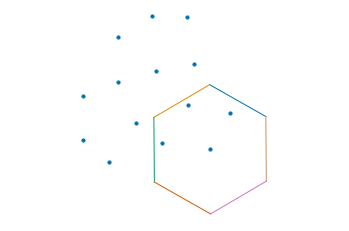

In [11]:
fig,ax=plt.subplots()
hexagons[-1].plot(fig,ax)
plt.scatter(*wrapped_phases.T,s=10)
plt.axis('equal')
plt.axis('off')

In [12]:
expanded_phases = np.concatenate([wrapped_phases - 2*model.unit_cell.basis[i] for i in range(6)],axis=0)
expanded_phases = np.concatenate([wrapped_phases, expanded_phases], axis=0)

In [13]:
nhexagon = Hexagon(model.unit_cell.radius,orientation,hexagons[-1].center)

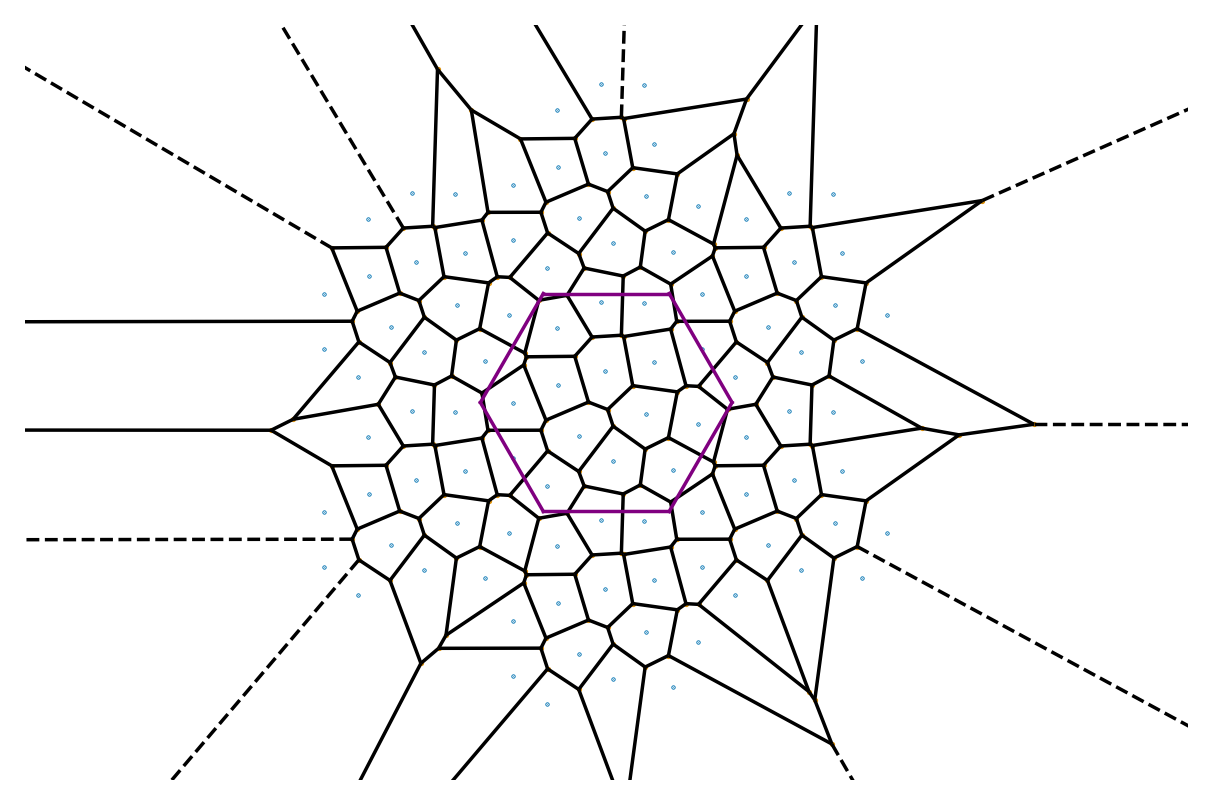

In [14]:
fig,ax = plt.subplots(dpi=250)
vor = Voronoi(expanded_phases)
voronoi_plot_2d(vor,ax)
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
#hexagons[-1].plot(fig,ax)
#nhexagon.plot(fig,ax)
model.unit_cell.plot(fig,ax,color='purple')
ax.axis('equal')
ax.axis('off')
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
fig.savefig('./results/voronoi')

In [15]:
res=100
magnitude_search = np.linspace(1,0,res)
rotation_search = np.linspace(0,60,res)
init_phases = np.concatenate([model.unit_cell.center[None], model.unit_cell.hpoints],axis=0)
#init_phases += np.random.uniform(size=(2,))
mesh = model.unit_cell.mesh(100)
line_loss = np.zeros((res,res))
for i in tqdm.trange(len(magnitude_search)):
    for j in range(len(rotation_search)):
        model.set_phases(magnitude_search[i]*init_phases@rotation_matrix(rotation_search[j]).T)
        model.set_scale()
        line_loss[i,j] = model.loss_fn(torch.tensor(mesh,dtype=torch.float32)).item()

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.68it/s]


In [16]:
model.set_phases(wrapped_phases)
np.min(line_loss), model.loss_fn(torch.tensor(mesh,dtype=torch.float32)).item()

(-5.545365810394287, 5.3448028564453125)

In [17]:
ind = np.unravel_index(np.argmin(line_loss, axis=None), line_loss.shape)
magnitude_search[ind[0]], magnitude_search[ind[0]-1], 2/3

(0.6565656565656566, 0.6666666666666666, 0.6666666666666666)

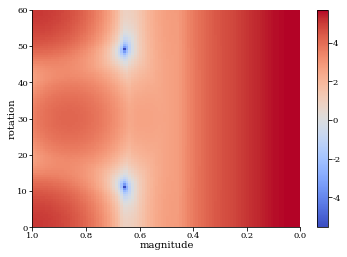

In [18]:
#plt.imshow(np.log(line_loss).T,origin='lower',
plt.imshow(line_loss.T,origin='lower',
           extent=[np.max(magnitude_search), np.min(magnitude_search), 
                   np.min(rotation_search), np.max(rotation_search)],cmap='coolwarm')
plt.xlabel('magnitude')
plt.ylabel('rotation')
plt.axis('auto')
plt.colorbar()

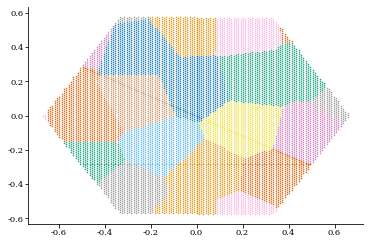

In [19]:
#model.set_phases(model.unit_cell.sample(20))
model.set_phases(wrapped_phases)
# SPATIAL VORONOI
voronoi_dists = np.stack([model.unit_cell.geodesic(mesh,wrapped_phases[i:i+1]) for i in range(len(phases))])
#voronoi_dists = np.stack([model.unit_cell.geodesic(mesh,model.phases.detach().numpy()[i:i+1]) for i in range(len(model.phases))])
vd_idxs = np.argmin(voronoi_dists,axis=0)
[plt.scatter(*mesh[vd_idxs==i].T) for i in range(len(model.phases))];

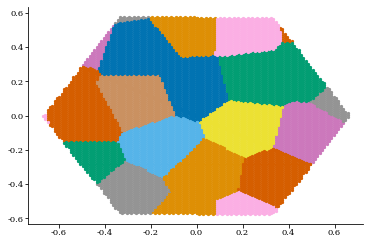

In [20]:
# FIRING RATE VORONOI
activity = model(torch.tensor(mesh,dtype=torch.float32)).detach().numpy()
activity_voronoi = np.argmax(activity,axis=-1) # cell with highest firing rate
#plt.scatter(*mesh.T,c=activity_voronoi)
[plt.scatter(*mesh[activity_voronoi==i].T,s=5) for i in range(len(model.phases))];

In [21]:
projection = umap.UMAP(n_neighbors=100,n_components=3)
manifold = projection.fit_transform(activity)

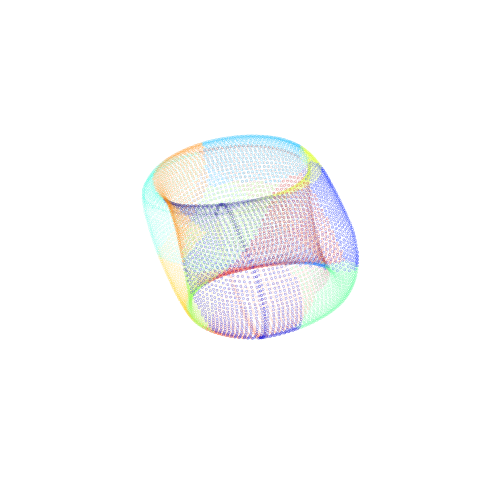

In [22]:
fig,ax = plt.subplots(dpi=150,subplot_kw={"projection": "3d"})
ax.scatter(*manifold.T,s=0.01,c=activity_voronoi,cmap='jet')
ax.axis('off')
ax.patch.set_alpha(0)

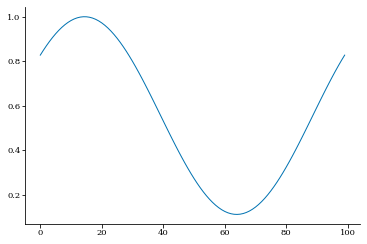

In [23]:
# monotonic
plt.plot(activity[::100,0])

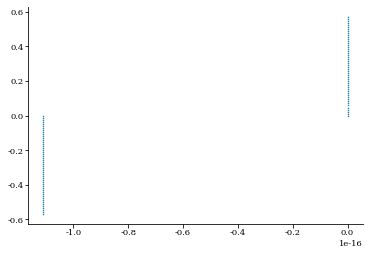

In [24]:
plt.scatter(*mesh[::100].T)

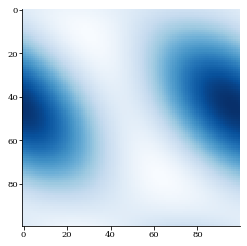

In [25]:
plt.imshow(activity[:,1].reshape(100,100))